In [1]:
from pathlib import Path
from copy import deepcopy
import numpy as np
import json
from typing import Dict
import networkx as nx
from matplotlib import pyplot as plt
import torch_geometric
from torch_geometric.data import Data
plt.rcParams['figure.figsize'] = [10, 8]
from src.envs.graph_coloring.gc_experimentation.problems import create_er_random_graph_problem
from src.envs.graph_coloring.gc_baselines.simple_policies import random_policy_without_newcolor
from src.envs.graph_coloring.gc_baselines.ortools_policy import ORToolsOfflinePolicy
from src.envs.graph_coloring.gc_policies.ppo_policy import PPOPolicy
from src.envs.graph_coloring.gc_utils.graph_utils import add_color_nodes_to_graph, create_graph_from_observation
from src.envs.graph_coloring.gc_utils.plot_results import plot_gc_solution

In [2]:
def calculate_reward_to_go(discount_factor, rewards):
    discounted_rewards = []
    for t in range(len(rewards)):
        rtg_t = 0
        for pw, r in enumerate(rewards[t:]):
            # normalize rewards by a constant number
            rtg_t = rtg_t + discount_factor ** pw * (r)
        discounted_rewards.append(rtg_t)
    return discounted_rewards

In [3]:
sim = create_er_random_graph_problem(num_new_nodes=0, num_initial_nodes=20, prob_edge=0.3,
                                   is_online=False, random_seed=15)

In [4]:
model_location = '../../../training/runs/gc/ppo_agent/2020-11-04_13_34_11'
with open(Path(model_location) / "agent_params.json") as f:
    agent_config_dict = json.load(f)
model_config_dict = agent_config_dict['model_config']
if "logit_normalizer" not in model_config_dict.keys():
    model_config_dict['logit_normalizer'] = agent_config_dict['logit_normalizer']

In [5]:
ppo_policy = PPOPolicy(agent_config_dict, model_config_dict, model_location, sim)
num_stochastic_runs = 50
num_seeds = 10
value_outputs = {'states': [],
                'state_value':[],
                'next_state_values':[],
                'rewards': []}
for i in range(num_seeds):
    sim.seed(10 + i)
    obs = sim.reset()
    is_done = False
    while not is_done:
        is_last_state = np.sum(obs["node_colors"] == -1) == 1
        if not is_last_state:
            value_next_states = []
            next_rewards = []
            for i in range(num_stochastic_runs):
                copy_sim = deepcopy(sim)
                action, _ = ppo_policy.get_action_and_value(obs, copy_sim)
                next_obs, reward, is_done, _ = copy_sim.step(action)
                _, next_value = ppo_policy.get_action_and_value(next_obs, copy_sim)
                value_next_states.append(next_value)
                next_rewards.append(reward)
        action, value_current_state = ppo_policy.get_action_and_value(obs, sim)
        if not is_last_state:
            value_outputs['states'].append(deepcopy(obs))
            value_outputs['next_state_values'].append(value_next_states)
            value_outputs['state_value'].append(value_current_state)
            value_outputs['rewards'].append(next_rewards)
        obs, reward, is_done, _ = sim.step(action)
graph_nx = create_graph_from_observation(obs)
graph_nx_colors = add_color_nodes_to_graph(obs)
#     plt.figure()
#     plot_gc_solution(graph_nx_colors, [])
graph_ppo = deepcopy(graph_nx_colors)
obs.keys()

Loading model file: ../../../training/runs/gc/ppo_agent/2020-11-04_13_34_11/model_ep_5801
device chosen:cpu


dict_keys(['node_colors', 'used_colors', 'nodes_id', 'edge_indexes', 'current_time', 'nodes_start_time', 'node_positions', 'color_adjacency_matrix'])

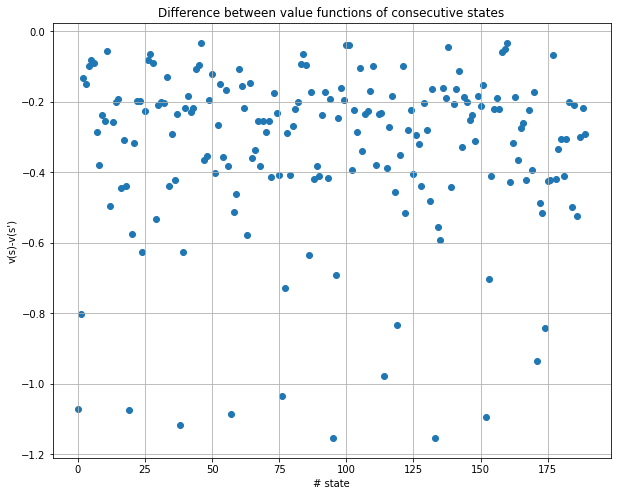

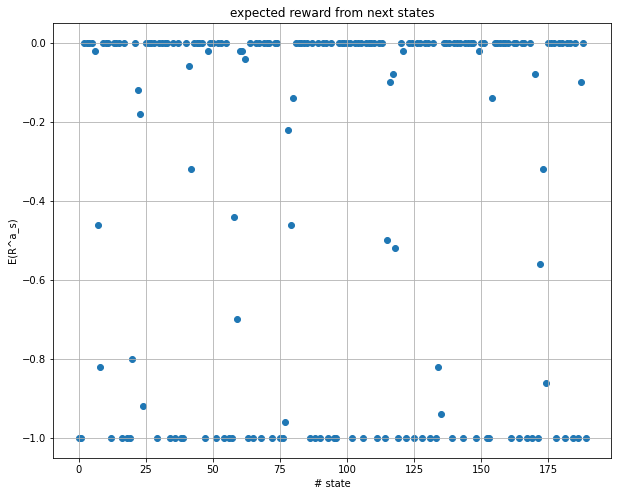

In [6]:
state_values = value_outputs["state_value"]
expected_next_state_values = [np.mean(v) for v in value_outputs["next_state_values"]]
expected_next_reward = np.array([np.mean(r) for r in value_outputs["rewards"]])
diff_values = np.array(state_values) - agent_config_dict['discount']*np.array(expected_next_state_values)
plt.scatter(range(diff_values.size), diff_values)
plt.xlabel('# state')
plt.ylabel("v(s)-v(s')")
plt.title('Difference between value functions of consecutive states')
plt.grid()
plt.figure()
plt.scatter(range(expected_next_reward.size), expected_next_reward)
plt.xlabel('# state')
plt.ylabel("E(R^a_s)")
plt.title('expected reward from next states')
plt.grid()

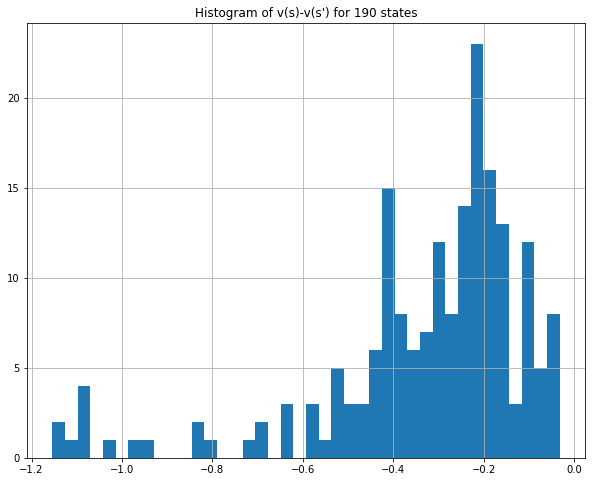

In [7]:
plt.hist(diff_values, bins = 40)
plt.title(f"Histogram of v(s)-v(s') for {diff_values.shape[0]} states")
plt.grid()

In [8]:
n_positive_diffs = np.sum(diff_values>0)
n_diffs = diff_values.shape[0]
print(f"percentage of positive v(s) - v(s') is:{100 * n_positive_diffs / n_diffs: .2f}%")

percentage of positive v(s) - v(s') is: 0.00%


In [21]:
for i_n in range(num_seeds):
    print(f"{i_n*(problem_size-1)}:{(i_n+1)*(problem_size-1)}")
len(rewards)

0:19
19:38
38:57
57:76
76:95
95:114
114:133
133:152
152:171
171:190


190

Text(0, 0.5, 'current expected reward')

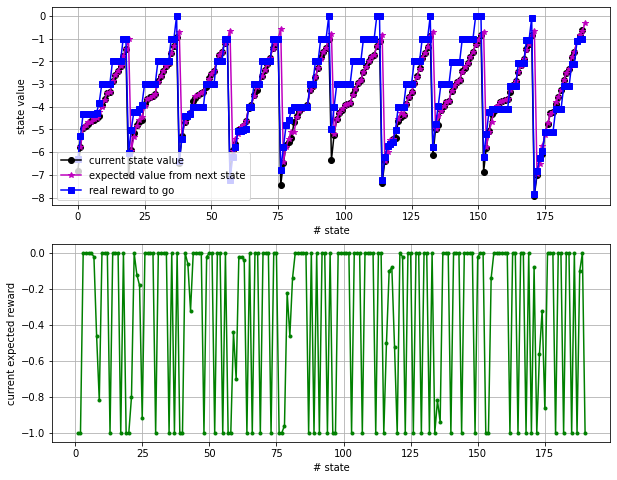

In [22]:
states = value_outputs["states"]
state_values = value_outputs["state_value"]
next_state_values = [np.mean(v) for v in value_outputs["next_state_values"]]
rewards = [np.mean(r) for r in value_outputs['rewards']]
problem_size=20
discounted_rewards = np.zeros(shape=len(rewards))
for i_n in range(num_seeds):
    current_rewards = rewards[i_n*(problem_size-1):(i_n+1)*(problem_size-1)]
    discounted_rewards[i_n*(problem_size-1):(i_n+1)*(problem_size-1)] = calculate_reward_to_go(discount_factor=agent_config_dict['discount'], rewards=current_rewards)
fig, ax = plt.subplots(2, 1)
ax[0].plot(range(len(state_values)), state_values, marker='o', c='k', label="current state value")
ax[0].plot(range(1, len(next_state_values)+1), next_state_values, marker='*', c='m', label="expected value from next state")
ax[0].plot(range(len(discounted_rewards)), discounted_rewards, marker='s', c='b', label="real reward to go")
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('# state')
ax[0].set_ylabel('state value')
ax[1].plot(range(1, len(rewards)+1), rewards, marker='.', c='g')
ax[1].grid()
ax[1].set_xlabel('# state')
ax[1].set_ylabel('current expected reward')
# print(f"state values:{state_values}")
# print(f"mean next state values:{[np.mean(v) for v in next_state_values][1:]}")

Text(0, 0.5, 'current expected reward')

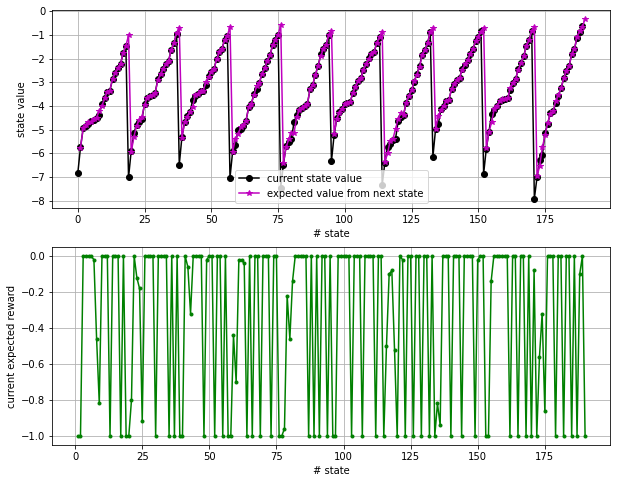

In [10]:
states = value_outputs["states"]
discounts = np.array([d**i for i, d in enumerate(np.ones(len(states))*agent_config_dict['discount'])])
state_values = np.array(value_outputs["state_value"]) * discounts
next_state_values = np.array([np.mean(v) for v in value_outputs["next_state_values"]]) * discounts
rewards = [np.mean(r) for r in value_outputs['rewards']]
fig, ax = plt.subplots(2, 1)
ax[0].plot(range(len(state_values)), state_values, marker='o', c='k', label="current state value")
ax[0].plot(range(1, len(next_state_values)+1), next_state_values, marker='*', c='m', label="expected value from next state")
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('# state')
ax[0].set_ylabel('state value')
ax[1].plot(range(1, len(rewards)+1), rewards, marker='.', c='g')
ax[1].grid()
ax[1].set_xlabel('# state')
ax[1].set_ylabel('current expected reward')

In [11]:
discounts

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])